<a href="https://colab.research.google.com/github/kchen79427/Capstone_Bruestle_Boudia_Chen/blob/dave_branch/Weather_Boudia_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=2b4a54d002da11d6cb2bc453de8cc18df3e8399440fb8d24a085e6e70ff53070
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Reshape, Lambda, RepeatVector, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import udf, expr, concat_ws
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import TimestampType
import json
from datetime import datetime
import pyarrow.parquet as pq
import seaborn as sns

In [3]:
print(tf.__version__)

2.12.0


In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

In [5]:
spark =  SparkSession.builder.master("local[*]") \
  .appName('Takeoff') \
  .getOrCreate()

In [6]:
spark.conf.set("spark.sql.inMemoryColumnarStorage.compressed", True)
spark.conf.set("spark.sql.shuffle.partitions",500)

# Helper Functions

In [7]:
# load json object for referencing filepaths
files = json.load(open('drive/Shareddrives/STUDENT-Capstone SS23/files.json','r'))

In [ ]:
def createFlightDT(fdate, ftime):
  # Creates a date-time timestamp
  lst = [x for x in str(ftime)]
  if len(lst) == 3:
    lst.insert(0,'0')
  lst.insert(2,':') # insert a column to delineate hour from min
  fdt = fdate + ' ' + "".join(lst) + ':00'
  return fdt

# Load Weather Training Data

In [ ]:
# Load Weather data from parquet into spark DataFrame
weather = spark.read.parquet(files['Weather']['DFW_train'])

In [ ]:
weather = weather.withColumn('WeatherDtTm1', to_timestamp('WeatherDtTm'))

In [ ]:
# If getting DFW Weather Specifically
weather.createOrReplaceTempView('weather')

In [ ]:
weather.columns

['Origin',
 'FlightDate',
 'CRSDepTime',
 'OriginDtTm',
 'WeatherDtTm',
 'w_dir_angle',
 'w_type',
 'w_speed_rate',
 'sky_c_hgt',
 'sky_c_det',
 'sky_c_cavok',
 'vis_dist',
 'vis_var',
 'tmp_air',
 'tmp_dew',
 'sea_lvl_p',
 'liq_precip_qty',
 'liq_precip_dim',
 'liq_precip_cond',
 'sky_cov',
 'sky_cov_base_hgt',
 'sky_cov_cld',
 'sky_sum_cov',
 'sky_sum_hgt',
 'sky_obs_tot_cov',
 'sky_low_cld_base_hgt',
 'at_pres_altimeter_rate',
 'at_pres_stn_rate',
 '__index_level_0__']

# Load Raw Flight Data

In [ ]:
spdf = spark.read.parquet('/content/drive/Shareddrives/STUDENT-Capstone SS23/BTS_data/OnTime_Parquet/OnTime_filtered_DFW_Only_Excludes_Years.parquet/part-00000-68a7ec0d-1a13-4f29-a8d6-e3c54e21d148-c000.snappy.parquet')

In [ ]:
# Create a Flight Date/Time Timestamp to be able to compare to the Weather Dataset
func = udf(lambda d,t: createFlightDT(d,t))
dfw = spdf.withColumn('Flight_DateTime', to_timestamp(func(spdf.FlightDate, spdf.CRSDepTime)))

In [ ]:
# Create a unique Flight ID for each flight for easy reference
dfw = dfw.withColumn('Flight_Num', concat_ws('_',spdf.DOT_ID_Reporting_Airline,
                                           spdf.Flight_Number_Reporting_Airline,
                                           spdf.FlightDate))

In [ ]:
dfw = dfw.withColumn('weather_wdw_start', col('Flight_DateTime') - expr('INTERVAL 3 HOURS'))

In [ ]:
dfw.createOrReplaceTempView('Ontime')

In [ ]:
tmp = spark.sql("""
            Select
              count(*)
            FROM
              Ontime
          """)
tmp.show()

+--------+
|count(1)|
+--------+
|  953680|
+--------+



In [ ]:
dfw_t = spark.sql("""SELECT * FROM Ontime""")
dfw_t.write.parquet('drive/Shareddrives/STUDENT-Capstone SS23/DFW_training_3H_window',mode='overwrite')

In [ ]:
dfw_t.createOrReplaceTempView('FData')

# Get Aircraft Data

In [ ]:
aircraft = spark.read.csv(files['Aircraft'],header=True)

In [ ]:
aircraft.show(1)

+---+-------+------+-------+--------------------+----------+----------+-----------+----------+-----------+
|_c0|tail_no|   mfr|  model|                type|passengers|wght_class|engine_type|no_engines|tail_prefix|
+---+-------+------+-------+--------------------+----------+----------+-----------+----------+-----------+
|  0| N301DQ|BOEING|737-732|Fixed Wing (Multi...|     149.0|   CLASS 3|   Turbofan|       2.0|          N|
+---+-------+------+-------+--------------------+----------+----------+-----------+----------+-----------+
only showing top 1 row



In [ ]:
aircraft.createOrReplaceTempView('Aircraft')

# Create Input Data (Flight + Aircraft Join)

In [ ]:
final_flight = spark.sql("""

                         SELECT
                          f.*
                         FROM
                          FData f INNER JOIN
                          Aircraft a
                          ON
                          f.Tail_Number = a.tail_no
                        WHERE
                          a.passengers >= 100
                         """
)

In [ ]:
# Execute Query and write to parquet file
final_flight.write.parquet('drive/Shareddrives/STUDENT-Capstone SS23/Final_Flight_3H', mode='overwrite')

In [ ]:
# Load the file back in
flight = spark.read.parquet('/content/drive/Shareddrives/STUDENT-Capstone SS23/RNN_Data/Final_Flight_3H/part-00000-a2a1f20f-1914-4fbb-982b-af345b4b6a80-c000.snappy.parquet')

In [ ]:
flight.createOrReplaceTempView('Flights')

In [ ]:
# Get the number of weather-related delays from our final flight data
tmp = spark.sql("""

                Select
                  Count(*)
                FROM
                  Flights
                WHERE
                  WeatherDelay >= 15
                """)
tmp.show()

+--------+
|count(1)|
+--------+
|    4372|
+--------+



# Combine Flight and Weather Data

In [ ]:
data = spark.sql("""
            Select
              f.Flight_Num,
              f.Flight_DateTime,
              f.weather_wdw_start,
              w.WeatherDtTm,
              f.WeatherDelay,
              w.w_dir_angle,
              w.w_type,
              w.w_speed_rate,
              w.sky_c_hgt,
              w.sky_c_det,
              w.sky_c_cavok,
              w.vis_dist,
              w.vis_var,
              w.tmp_air,
              w.tmp_dew,
              w.sea_lvl_p,
              w.liq_precip_qty,
              w.liq_precip_dim,
              w.liq_precip_cond,
              w.sky_cov,
              w.sky_cov_base_hgt,
              w.sky_cov_cld,
              w.sky_sum_cov,
              w.sky_sum_hgt,
              w.sky_obs_tot_cov,
              w.sky_low_cld_base_hgt,
              w.at_pres_altimeter_rate,
              w.at_pres_stn_rate
            FROM
              Flights f,
              weather w
            WHERE
              w.WeatherDtTm1 Between f.weather_wdw_start AND  f.Flight_DateTime AND
              f.DepTime <> ''
              """
)



In [ ]:
data.write.parquet('/content/drive/Shareddrives/STUDENT-Capstone SS23/Model_Data_3H', mode='overwrite')

# Sequence The Combined Data

In [ ]:
data = spark.read.parquet('/content/drive/Shareddrives/STUDENT-Capstone SS23/RNN_Data/Model_Data_3H/part-00000-b1bc7529-2f00-477a-8a13-57f5a46b0b67-c000.snappy.parquet')

In [ ]:
# data.count()
data.createOrReplaceTempView('alldata')
data.columns

['Flight_Num',
 'Flight_DateTime',
 'weather_wdw_start',
 'WeatherDtTm',
 'WeatherDelay',
 'w_dir_angle',
 'w_type',
 'w_speed_rate',
 'sky_c_hgt',
 'sky_c_det',
 'sky_c_cavok',
 'vis_dist',
 'vis_var',
 'tmp_air',
 'tmp_dew',
 'sea_lvl_p',
 'liq_precip_qty',
 'liq_precip_dim',
 'liq_precip_cond',
 'sky_cov',
 'sky_cov_base_hgt',
 'sky_cov_cld',
 'sky_sum_cov',
 'sky_sum_hgt',
 'sky_obs_tot_cov',
 'sky_low_cld_base_hgt',
 'at_pres_altimeter_rate',
 'at_pres_stn_rate']

In [ ]:
# Confirm we're getting the same delays as seen prior
tmp = spark.sql("""
                Select Count(Total)
                FROM
                (Select
                  Flight_Num, Count(*) as Total
                FROM
                  alldata
                WHERE
                  WeatherDelay >= 15
                GROUP BY
                  Flight_Num) z
                """)
tmp.show()

+------------+
|count(Total)|
+------------+
|        4372|
+------------+



In [ ]:
tmp = spark.sql("""
                Select
                  z.Total as Flight_Time_Steps,
                  Count(z.Total) as Frequency
                FROM
                (Select
                  Flight_Num, Max(Time_Sequence) as Total
                FROM
                  alldata
                GROUP BY
                  Flight_Num) z
                GROUP BY
                  z.Total
                ORDER BY z.Total ASC
                """)
tmp.show()

+-----------------+---------+
|Flight_Time_Steps|Frequency|
+-----------------+---------+
|                3|     1472|
|                4|   185094|
|                5|    64249|
|                6|    21056|
|                7|    10917|
|                8|     6690|
|                9|     3710|
|               10|     2158|
|               11|     1375|
|               12|      867|
|               13|      444|
|               14|      295|
|               15|      205|
|               16|      101|
|               17|       59|
|               18|       14|
|               19|        4|
|               20|        3|
|               21|        2|
+-----------------+---------+



In [ ]:
ts.count()

1420510

In [ ]:
ts = spark.sql("""

          SELECT
            *,
            Dense_Rank() OVER(PARTITION BY Flight_Num ORDER BY WeatherDtTm ASC) Time_Sequence
          FROM
            alldata
          """)

In [ ]:
ts.write.parquet('/content/drive/Shareddrives/STUDENT-Capstone SS23/Model_Data_3H_Sequenced')

In [ ]:
# The last step step split the file into separate partitions and will need to be recombined.
# Source: https://stackoverflow.com/questions/75468395/merge-small-parquet-files-into-a-single-large-parquet-file#:~:text=You%20can%20open%20files%20one,to%20use%20pyarrow%20for%20this.&text=For%20large%20data%20you%20should,is%20very%20similar%20to%20Pandas.https://stackoverflow.com/questions/75468395/merge-small-parquet-files-into-a-single-large-parquet-file#:~:text=You%20can%20open%20files%20one,to%20use%20pyarrow%20for%20this.&text=For%20large%20data%20you%20should,is%20very%20similar%20to%20Pandas.
file1 = '/content/drive/Shareddrives/STUDENT-Capstone SS23/RNN_Data/Model_Data_3H_Sequenced/part-00000-de453764-e6b6-4dca-96c1-dfb08f3efa90-c000.snappy.parquet'
file2 = '/content/drive/Shareddrives/STUDENT-Capstone SS23/RNN_Data/Model_Data_3H_Sequenced/part-00001-de453764-e6b6-4dca-96c1-dfb08f3efa90-c000.snappy.parquet'

files = [file1, file2]
with pq.ParquetWriter("/content/drive/Shareddrives/STUDENT-Capstone SS23/RNN_Data/input.parquet", schema=pq.ParquetFile(files[0]).schema_arrow) as writer:
    for file in files:
        writer.write_table(pq.read_table(file))



In [8]:
ts = spark.read.parquet('/content/drive/Shareddrives/STUDENT-Capstone SS23/RNN_Data/input.parquet')
ts.createOrReplaceTempView('alldata')

In [9]:
ts.columns

['Flight_Num',
 'Flight_DateTime',
 'weather_wdw_start',
 'WeatherDtTm',
 'WeatherDelay',
 'w_dir_angle',
 'w_type',
 'w_speed_rate',
 'sky_c_hgt',
 'sky_c_det',
 'sky_c_cavok',
 'vis_dist',
 'vis_var',
 'tmp_air',
 'tmp_dew',
 'sea_lvl_p',
 'liq_precip_qty',
 'liq_precip_dim',
 'liq_precip_cond',
 'sky_cov',
 'sky_cov_base_hgt',
 'sky_cov_cld',
 'sky_sum_cov',
 'sky_sum_hgt',
 'sky_obs_tot_cov',
 'sky_low_cld_base_hgt',
 'at_pres_altimeter_rate',
 'at_pres_stn_rate',
 'Time_Sequence']

In [10]:
df = ts.toPandas()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [12]:
int_cols = ['w_dir_angle',
 'w_type',
 'w_speed_rate',
 'sky_c_hgt',
 'sky_c_det',
 'sky_c_cavok',
 'vis_dist',
 'vis_var',
 'tmp_air',
 'tmp_dew',
 'sea_lvl_p',
 'liq_precip_qty',
 'liq_precip_dim',
 'liq_precip_cond',
 'sky_cov',
 'sky_cov_base_hgt',
 'sky_cov_cld',
 'sky_sum_cov',
 'sky_sum_hgt']

In [38]:
df.sky_cov_cld.value_counts()

99      1399472
09        14369
12         5653
02          825
00           95
99.0         89
07            7
Name: sky_cov_cld, dtype: int64

In [40]:
# Update the columns to appropriate dtypes
df['liq_precip_qty'] = df['liq_precip_qty'].astype('float64')
df['sky_cov'] = df['sky_cov'].astype('float64')
df['sky_cov_cld'] = df['sky_cov_cld'].astype('float64')

In [44]:
weather_vars = df.iloc[:, 5:].select_dtypes(include=['int64','float64']).columns
df_mean = df.groupby('Flight_Num')[weather_vars].mean()

In [45]:
df_mean.shape

(298715, 18)

<Axes: >

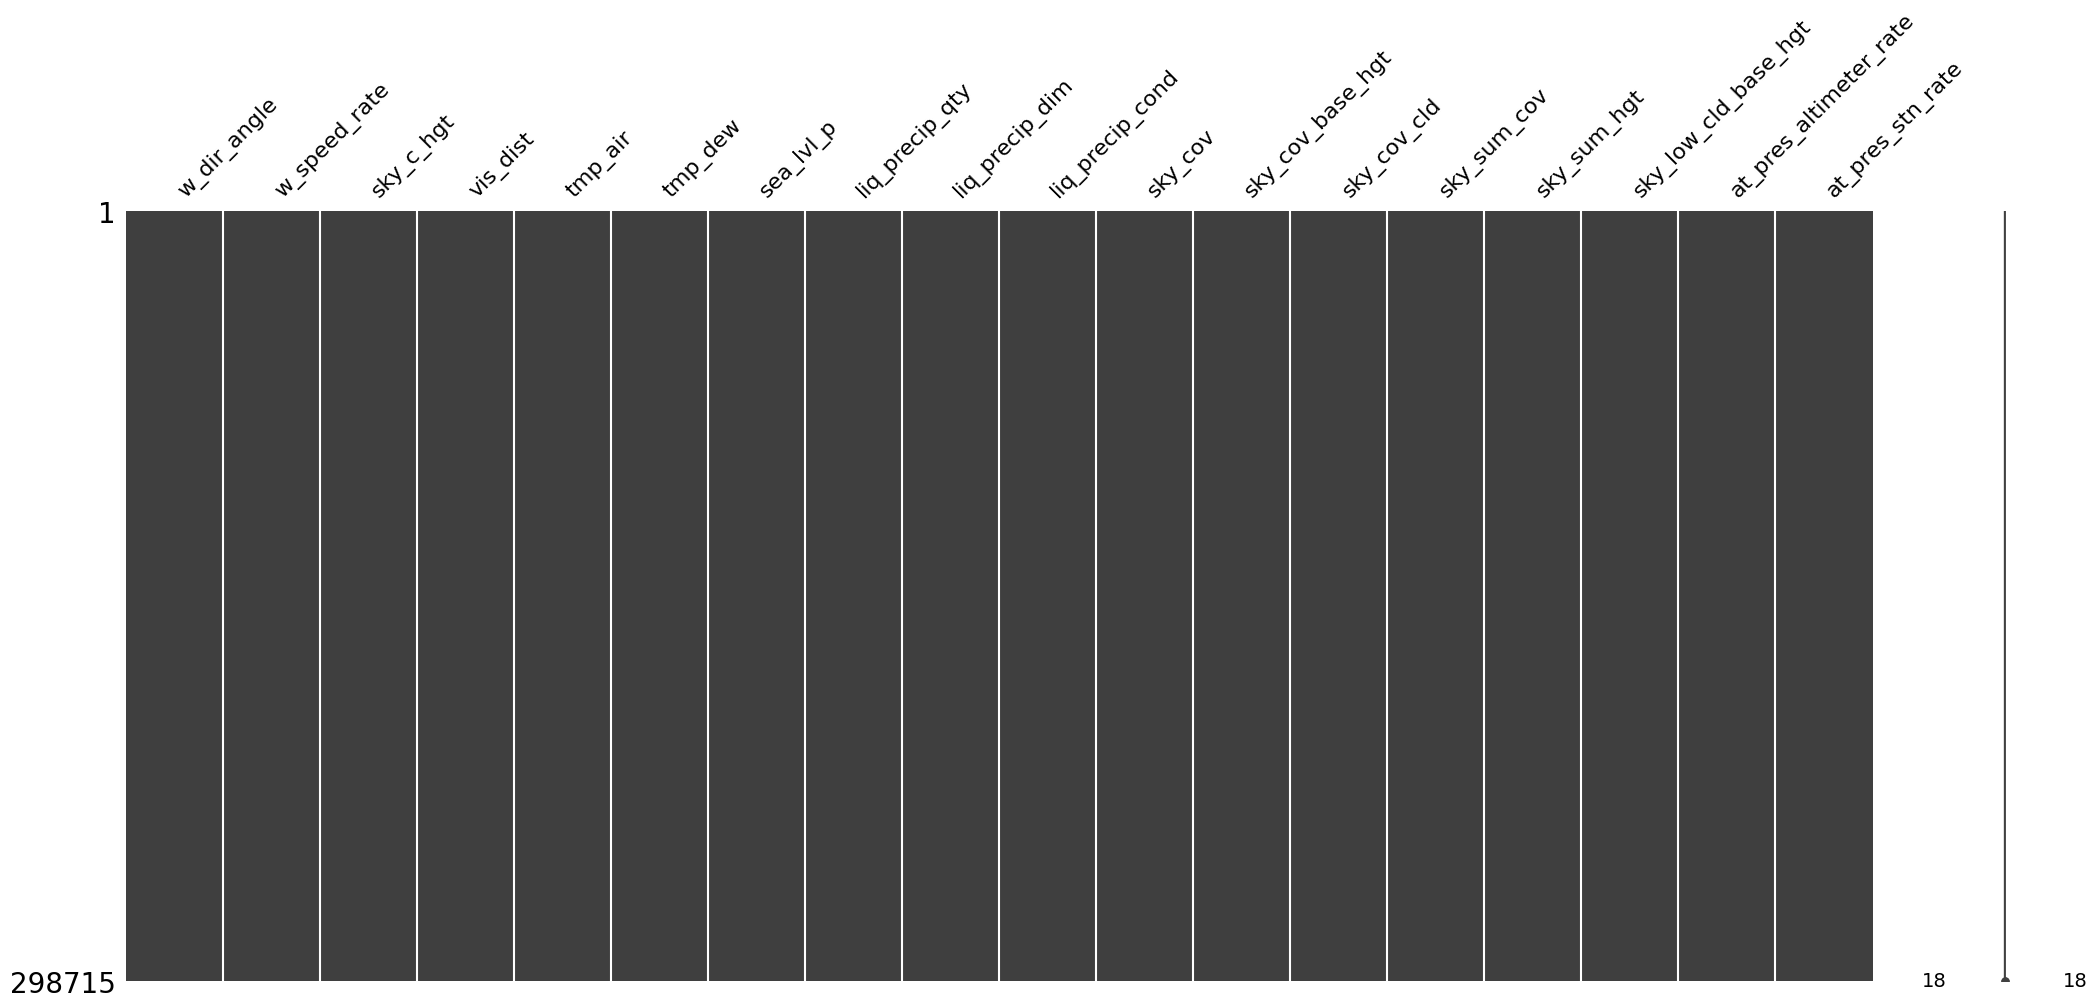

In [48]:
import missingno as msn
msn.matrix(df_mean)

In [51]:
df_mean.head()

,w_dir_angle,w_speed_rate,sky_c_hgt,vis_dist,tmp_air,tmp_dew,sea_lvl_p,liq_precip_qty,liq_precip_dim,liq_precip_cond,sky_cov,sky_cov_base_hgt,sky_cov_cld,sky_sum_cov,sky_sum_hgt,sky_low_cld_base_hgt,at_pres_altimeter_rate,at_pres_stn_rate
Flight_Num,,,,,,,,,,,,,,,,,,
19704_1014_2010-01-26,401.800000,2031.600000,47447.600000,212855.6,2064.400000,1962.200000,28148.600000,25.2,1999.800000,9.0,40.800000,42864.800000,99.000000,4.200000,42864.800000,99999.000000,46112.200000,27977.800000
19704_1014_2010-04-22,329.800000,2035.600000,37599.800000,212855.6,2159.800000,2106.200000,28058.600000,25.2,1999.800000,9.0,41.600000,45181.200000,99.000000,4.600000,45181.200000,99999.000000,46048.200000,27893.600000
19704_1014_2010-04-23,321.800000,2050.400000,40365.600000,212855.6,2169.800000,2134.400000,28011.400000,6.6,0.000000,6.2,44.200000,40365.600000,99.000000,5.800000,40365.600000,80159.200000,46012.400000,27846.400000
19704_1014_2010-04-24,379.857143,1480.571429,30617.714286,154544.0,1600.857143,1513.714286,48584.857143,19.0,1439.285714,8.0,30.285714,29542.142857,60.428571,3.571429,29542.142857,85827.714286,35730.428571,22695.857143
19704_1014_2010-04-25,439.800000,2048.000000,37599.800000,212855.6,2151.000000,2059.600000,28038.400000,25.2,2015.600000,9.0,79.200000,99999.000000,99.000000,9.000000,99999.000000,99999.000000,46032.800000,27873.400000


In [47]:
dly = df.groupby('Flight_Num')['WeatherDelay'].agg('first').value_counts()
dly[dly > 10].shape

In [ ]:
ts.write.parquet('Model_Data_3H_Sequenced',mode='overwrite')

In [ ]:
dw_g = dw.groupby('Flight_Num')[['T_x']].count()
flights = dw_g[dw_g['T_x'] > 20].index

In [ ]:
lst = []
grp = dw[dw['Flight_Num'].isin(flights)].groupby('Flight_Num')
for k,f in grp:
  lst.append(f.head(20))
final = pd.concat(lst)

In [ ]:
len(final.Flight_Num.unique()), final.shape

(220, (4400, 7))

In [ ]:
nf = final.values.reshape(220,20,7)

In [ ]:
nf[0][1]

array(['19805_1004_2014-08-17', Timestamp('2014-08-17 18:53:00'), 1.0,
       2.0, 57, '+0244', 2], dtype=object)

# Analysis of Weather Variables

In [ ]:
df['DW'] = df['WeatherDelay'].apply(lambda x: 1 if pd.isnull(x) == False and x >= 15 else 0)

In [ ]:

w_speed_rate = df.groupby('Flight_Num')['w_speed_rate'].agg('last')
test = pd.merge(df[['Flight_Num','DW']], w_speed_rate, how='inner', left_on='Flight_Num', right_on=w_speed_rate.index)




In [ ]:
sns.regplot(data=test,
            x='w_speed_rate',
            y='DW',
            logistic=True)

# Create Input For Model

---



In [ ]:
test = df.sample(20000)
test['DW'] = test['WeatherDelay'].apply(lambda x: 1 if pd.isnull(x) == False and x >= 15 else 0)
y = df.groupby('Flight_Num')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
c = test.groupby('Flight_Num')['Time_Sequence'].count()
c = c[c==2]
ntest = test[test['Flight_Num'].isin(c.index)]
num = ntest.DW.value_counts()[1]
pos = ntest[ntest['DW']==1]
neg = ntest[ntest['DW']==0].sample(num)
ok = pd.concat([pos,neg])
ok = ok.sample(frac=1)



In [ ]:
ok

,Flight_Num,Flight_DateTime,weather_wdw_start,WeatherDtTm,WeatherDelay,w_dir_angle,w_type,w_speed_rate,sky_c_hgt,sky_c_det,sky_c_cavok,vis_dist,vis_var,tmp_air,tmp_dew,sea_lvl_p,liq_precip_qty,liq_precip_dim,liq_precip_cond,sky_cov,sky_cov_base_hgt,sky_cov_cld,sky_sum_cov,sky_sum_hgt,sky_obs_tot_cov,sky_low_cld_base_hgt,at_pres_altimeter_rate,at_pres_stn_rate,Time_Sequence,DW
564942,19805_523_2011-12-15,2011-12-15 19:45:00,2011-12-15 16:45:00,2011-12-15 18:00:00,20.0,40,N,62,99999,9,N,16000,N,111,67,10198,06,0,2,99,99999,99,9,99999,08,450,99999,9994,3,1
901609,19805_1452_2011-08-26,2011-08-26 20:45:00,2011-08-26 17:45:00,2011-08-26 19:53:00,NaN,999,C,0,22000,9,N,16093,N,389,167,10117,01,0,9,04,2743,99,2,2743,04,99999,10129,9912,4,0
189105,19805_1441_2018-09-20,2018-09-20 17:10:00,2018-09-20 14:10:00,2018-09-20 16:53:00,162.0,160,N,67,22000,9,N,16093,N,300,211,10139,01,0,9,02,914,99,1,914,99,914,10149,9932,4,1
259388,19805_1633_2015-01-19,2015-01-19 10:45:00,2015-01-19 07:45:00,2015-01-19 09:00:00,NaN,200,N,46,99999,9,N,16000,9,61,-17,10174,99,9999,9,99,99999,99,9,99999,00,99999,99999,9971,3,0
999334,19805_1744_2019-12-28,2019-12-28 22:28:00,2019-12-28 19:28:00,2019-12-28 20:27:00,0.0,180,N,88,457,M,N,14484,N,189,167,99999,01,0,2,07,457,99,3,457,99,457,10027,9812,3,0
1048942,19805_2039_2019-03-09,2019-03-09 06:55:00,2019-03-09 03:55:00,2019-03-09 06:51:00,86.0,190,N,93,488,M,N,16093,N,210,180,99999,99,9999,9,08,488,99,4,488,99,99999,10047,9832,7,1
1048941,19805_2039_2019-03-09,2019-03-09 06:55:00,2019-03-09 03:55:00,2019-03-09 06:15:00,86.0,180,N,108,427,M,N,16093,N,211,183,99999,99,9999,9,08,427,99,4,427,99,427,10047,9832,6,1
427573,19805_2363_2019-03-13,2019-03-13 09:55:00,2019-03-13 06:55:00,2019-03-13 08:53:00,17.0,160,N,108,274,M,N,9656,N,189,172,10003,01,0,2,08,274,09,4,274,99,274,10010,9795,5,1
354126,19805_2207_2019-03-13,2019-03-13 18:45:00,2019-03-13 15:45:00,2019-03-13 18:00:00,58.0,180,N,82,22000,9,N,16000,9,172,117,10016,06,30,3,99,450,99,9,99999,02,450,99999,9818,4,1
838227,19805_1279_2011-02-04,2011-02-04 13:10:00,2011-02-04 10:10:00,2011-02-04 11:37:00,42.0,330,N,46,1433,M,N,8047,N,-70,-90,99999,01,3,9,02,945,99,1,945,08,99999,10254,10035,3,1


In [ ]:
cols = ['w_dir_angle', 'w_type', 'w_speed_rate', 'sky_c_hgt',
       'sky_c_det', 'sky_c_cavok', 'vis_dist', 'vis_var', 'tmp_air', 'tmp_dew',
       'sea_lvl_p', 'liq_precip_qty', 'liq_precip_dim', 'liq_precip_cond',
       'sky_cov', 'sky_cov_base_hgt', 'sky_cov_cld', 'sky_sum_cov',
       'sky_sum_hgt', 'sky_obs_tot_cov', 'sky_low_cld_base_hgt',
       'at_pres_altimeter_rate', 'at_pres_stn_rate']

In [ ]:
X = None
y = []

for grp, frame in ok.groupby('Flight_Num'):
    frame = frame.sort_values('WeatherDtTm')
    frame = frame.head(2).select_dtypes(include=['int64','float64'])
    y.append(frame['DW'].unique()[0])
    frame.drop(columns=['WeatherDelay','DW'],axis=1,inplace=True)
    frame[frame.columns] = frame[frame.columns].astype('float64')
    r,c = frame.values.shape
    frame = frame.head(2).values.reshape(1,2,c)
    if X is None:
      X = frame
    else:
      X = np.vstack((X,frame))


ValueError: ignored

In [ ]:
y = [i if pd.isnull(i) == False else 0 for i in y]
y = np.array(y)
y = np.reshape(y,(-1,1))

# Model Build

In [ ]:
dropout=0.2
output_dim=10
neurons=128*6
epochs=100
batch_size=128*4

In [ ]:
# Neural network set up
model = Sequential()

#Hidden Layer 1 - LSTM
model.add(LSTM(units=neurons,recurrent_dropout=dropout,return_sequences=True))

#Hidden Layer 2 - LSTM
model.add(LSTM(units=neurons,recurrent_dropout=dropout))

#Hidden Layer 3 - LSTM
# model.add(LSTM(units=neurons,recurrent_dropout=dropout))

#Output Layer with Sigmoid
model.add(Dense(1, activation='sigmoid'))
model.compile(
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X,y, epochs=20, verbose=1)

Epoch 1/20
18/18 [==============================] - 7s 391ms/step - loss: 0.1038 - accuracy: 0.9691
Epoch 2/20
14/18 [======================>.......] - ETA: 1s - loss: 0.1146 - accuracy: 0.9665

KeyboardInterrupt: ignored

In [ ]:
df = w.toPandas()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [ ]:
df.head(10)

,Origin,FlightDate,CRSDepTime,OriginDtTm,WeatherDtTm,w_dir_angle,w_dir_qlty,w_type,w_speed_rate,w_speed_qlty,...,sky_sum_cov,sky_sum_hgt,sky_sum_hgt_qlty,sky_obs_tot_cov,sky_obs_qlty_tot_cov,sky_low_cld_base_hgt,sky_low_cld_base_hgt_qlty,at_pres_altimeter_rate,at_pres_stn_rate,__index_level_0__
0,DFW,2014-08-17,1000,2014-08-17 10:00:00,2014-08-17 09:00:00,100,1,N,26,1,...,9,None,99999,6,1,2250,1,99999,9921,246570
1,DFW,2014-08-17,1000,2014-08-17 10:00:00,2014-08-17 09:00:00,100,1,N,26,1,...,9,None,99999,6,1,2250,1,99999,9921,246571
2,DFW,2014-08-17,1000,2014-08-17 10:00:00,2014-08-17 09:00:00,100,1,N,26,1,...,9,None,99999,6,1,2250,1,99999,9921,246572
3,DFW,2014-08-17,1000,2014-08-17 10:00:00,2014-08-17 09:00:00,100,1,N,26,1,...,9,None,99999,6,1,2250,1,99999,9921,246573
4,DFW,2014-08-17,1005,2014-08-17 10:05:00,2014-08-17 09:00:00,100,1,N,26,1,...,9,None,99999,6,1,2250,1,99999,9921,246574
5,DFW,2014-08-17,1005,2014-08-17 10:05:00,2014-08-17 09:00:00,100,1,N,26,1,...,9,None,99999,6,1,2250,1,99999,9921,246575
6,DFW,2014-08-17,1005,2014-08-17 10:05:00,2014-08-17 09:00:00,100,1,N,26,1,...,9,None,99999,6,1,2250,1,99999,9921,246576
7,DFW,2014-08-17,1010,2014-08-17 10:10:00,2014-08-17 09:00:00,100,1,N,26,1,...,9,None,99999,6,1,2250,1,99999,9921,246577
8,DFW,2014-08-17,1010,2014-08-17 10:10:00,2014-08-17 09:00:00,100,1,N,26,1,...,9,None,99999,6,1,2250,1,99999,9921,246578
9,DFW,2014-08-17,1010,2014-08-17 10:10:00,2014-08-17 09:00:00,100,1,N,26,1,...,9,None,99999,6,1,2250,1,99999,9921,246579


In [ ]:
flights = spark.sql("""
                      Select
                        *
                      FROM
                        Ontime
                      WHERE
                        Origin='DFW' and
                        FlightDate = '2014-08-17'

                    """)


In [ ]:
flights.show(2)

+-------------+----+---------+---------------+------------------------+-------------+----------+---------------+-------------+--------+-------+---------------+------------------+-----------------+------+----+--------+-------------------------------+---------------+------------+------------------+------------+-----+----------------+----------+---------------+-------+--------+-------+------------------+-------------+----------+---------+------------+--------+--------------+---------+----------------+------+--------------------+--------+----------+-----------------+---------+--------+--------+-------+-------+----------+-----------+----------+---------------+-----------------+
|DestStateFips|Dest|Cancelled|LongestAddGTime|DOT_ID_Reporting_Airline|TotalAddGTime|DepTimeBlk|OriginStateFips|SecurityDelay|ArrDel15|TaxiOut|ArrDelayMinutes|ArrivalDelayGroups|ActualElapsedTime|TaxiIn|Year|NASDelay|Flight_Number_Reporting_Airline|DepDelayMinutes|CarrierDelay|OriginAirportSeqID|FirstDepTime|Month|De

In [ ]:
df.head(20)

,Flight_Number_Reporting_Airline,WeatherDelay,DepDel15,FlightDate
0,71,146.0,1.0,2014-08-17
1,72,NaN,0.0,2014-08-17
2,73,58.0,1.0,2014-08-17
3,79,31.0,1.0,2014-08-17
4,81,101.0,1.0,2014-08-17
5,88,49.0,1.0,2014-08-17
6,90,120.0,1.0,2014-08-17
7,96,0.0,1.0,2014-08-17
8,138,11.0,1.0,2014-08-17
9,140,NaN,NaN,2014-08-17


In [ ]:
train = spark.read.parquet(files['BTS']['DFW_train'])

In [ ]:
test = spark.read.parquet(files['BTS']['DFW_test'])

In [ ]:
train.show(1)

+-------------+----+---------+---------------+------------------------+-------------+----------+---------------+-------------+--------+-------+---------------+------------------+-----------------+------+----+--------+-------------------------------+---------------+------------+------------------+------------+-----+----------------+----------+---------------+-------+--------+-------+------------------+-------------+----------+---------+------------+--------+--------------+---------+----------------+------+--------------------+--------+----------+-----------------+---------+--------+--------+-------+-------+----------+-----------+
|DestStateFips|Dest|Cancelled|LongestAddGTime|DOT_ID_Reporting_Airline|TotalAddGTime|DepTimeBlk|OriginStateFips|SecurityDelay|ArrDel15|TaxiOut|ArrDelayMinutes|ArrivalDelayGroups|ActualElapsedTime|TaxiIn|Year|NASDelay|Flight_Number_Reporting_Airline|DepDelayMinutes|CarrierDelay|OriginAirportSeqID|FirstDepTime|Month|DestAirportSeqID|CRSDepTime|OriginAirportID|Dep

In [ ]:
pd.read_csv(files['Carriers'])

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.
...,...,...
1716,ZW,Air Wisconsin Airlines Corp
1717,ZX,Air Georgian
1718,ZX (1),Airbc Ltd.
1719,ZY,Atlantic Gulf Airlines


In [ ]:
md = spark.read.parquet('/content/drive/Shareddrives/STUDENT-Capstone SS23/Model_Data/DFW_All_Flight_Measurements/part-00000-76e08f2d-0866-4947-b3ca-489c635d74c8-c000.snappy.parquet')

In [ ]:
md.show(5)

+-------------------+-------------------+-------------------+------------+-----------+------+------------+---------+---------+-----------+--------+-------+-------+-------+---------+--------------+--------------+---------------+-------+----------------+-----------+-----------+-----------+---------------+--------------------+----------------------+----------------+
|         Flight_Num|    Flight_DateTime|        WeatherDtTm|WeatherDelay|w_dir_angle|w_type|w_speed_rate|sky_c_hgt|sky_c_det|sky_c_cavok|vis_dist|vis_var|tmp_air|tmp_dew|sea_lvl_p|liq_precip_qty|liq_precip_dim|liq_precip_cond|sky_cov|sky_cov_base_hgt|sky_cov_cld|sky_sum_cov|sky_sum_hgt|sky_obs_tot_cov|sky_low_cld_base_hgt|at_pres_altimeter_rate|at_pres_stn_rate|
+-------------------+-------------------+-------------------+------------+-----------+------+------------+---------+---------+-----------+--------+-------+-------+-------+---------+--------------+--------------+---------------+-------+----------------+-----------+----

In [54]:
dfw_train = spark.read.parquet('/content/drive/Shareddrives/STUDENT-Capstone SS23/BTS_data/OnTime_WithWeather/OnTime_w_Weather_10_19.parquet', header=True)

In [57]:
dfw_train.

+----+----+-------+-----+----------+---------+----------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+----+---------------+---------+-------------+-------------+-------+----------+-------+--------+---------------+--------+--------------------+----------+-------+---------+--------+------+----------+-------+--------+---------------+--------+------------------+----------+---------+----------------+--------+--------------+-----------------+-------+-------+--------+-------------+------------+------------+--------+-------------+-----------------+-------------+---------------+-----------------+------------+--------------------+----------+----------+-----------+----------+-----------+------------------------+-------------------+-----------+----